# Effect of prominent Macroeconomic factors on the Housing Price Index in the United States

## Load Packages

In [76]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import math

## Load Data

### Variables
- Purchase only house price index: asdf
- Unemployment rate: asdf
- Consumer price index: asdf
- Inflation rate US: asdf
- Consumer sentiment: asdf
- Producer price index construction machinery manufacturing: asdf
- Average mortgage interest: asdf
- Personal income: asdf
- Moody's seasoned AAA corporate bond yield: asdf
- Home supply: asdf

## Import data

In [4]:
# define series_id
series_id_dict = {"house_pi": 'HPIPONM226S',
                 "unemp_rate": "UNRATE",
                 "CPI": "USACPIALLMINMEI",
                 "cons_sent": "UMCSENT",
                 "PI_const": "PCU333120333120",
                 "mortgage_int": "MORTGAGE30US",
                 "personal_inc": "PI",
                 "corp_yield": "AAA",
                 "home_supply": "MSACSR"}

# get data folder path
project_name = "housing-price-index-us"
raw_data_path = os.path.join(os.environ["RESEARCH_PATH"], project_name, "data", "raw")

# get filename
observation_start = "2000-01-01"
observation_end = "2022-06-30"

filename_list = []
for id in series_id_dict:
    filename_list.append(f"data_{series_id_dict[id]}_{observation_start}_to_{observation_end}.feather")


# call the function to fetch the data from FRED API
#data = pd.read_feather(os.path.join(raw_data_path, filename_list[0]))
data = pd.read_feather(os.path.join(raw_data_path, filename_list[0])).iloc[:,0:1]
    
# join all data together in a single pd.DataFrame
temp = 0
for key, value in series_id_dict.items():
    data[key] = pd.read_feather(os.path.join(raw_data_path, filename_list[temp])).iloc[:,1:]
    temp += 1

# change data type to float for all columns (but date)
for key, value in series_id_dict.items():
    data[key] = pd.to_numeric(data[key])

data['date'] = pd.to_datetime(data['date'])        

#print(data)

          date  house_pi  unemp_rate         CPI  cons_sent  PI_const  \
0   2000-01-01    137.10         4.0   71.218520      112.0   172.300   
1   2000-02-01    136.90         4.1   71.640431      111.3   172.300   
2   2000-03-01    137.97         4.0   72.231106      107.1   172.400   
3   2000-04-01    138.91         3.8   72.273297      109.2   172.700   
4   2000-05-01    139.49         4.0   72.357679      110.7   172.600   
..         ...       ...         ...         ...        ...       ...   
265 2022-02-01    380.38         3.8  119.702806       62.8   293.693   
266 2022-03-01    386.07         3.6  121.301004       59.4   294.221   
267 2022-04-01    392.33         3.6  121.978170       65.2   302.832   
268 2022-05-01    396.92         3.6  123.322800       58.4   304.699   
269 2022-06-01    397.14         3.6  125.016771       50.0   305.899   

     mortgage_int  personal_inc  corp_yield  home_supply  
0            8.21        8382.6        7.78          4.3  
1    

## EDA

### preliminary/high-level EDA

In [11]:
#print(data.head())
print('******************************************************************************************')
#print(data.shape)
print('******************************************************************************************')
#print(data.dtypes) # all floats except for 'date' which is datetime
print('******************************************************************************************')
#print(data.info())
print('******************************************************************************************')
print(data.isnull().sum()) # no null data

******************************************************************************************
(270, 10)
******************************************************************************************
date            datetime64[ns]
house_pi               float64
unemp_rate             float64
CPI                    float64
cons_sent              float64
PI_const               float64
mortgage_int           float64
personal_inc           float64
corp_yield             float64
home_supply            float64
dtype: object
******************************************************************************************
******************************************************************************************
date            0
house_pi        0
unemp_rate      0
CPI             0
cons_sent       0
PI_const        0
mortgage_int    0
personal_inc    0
corp_yield      0
home_supply     0
dtype: int64


### some further EDA

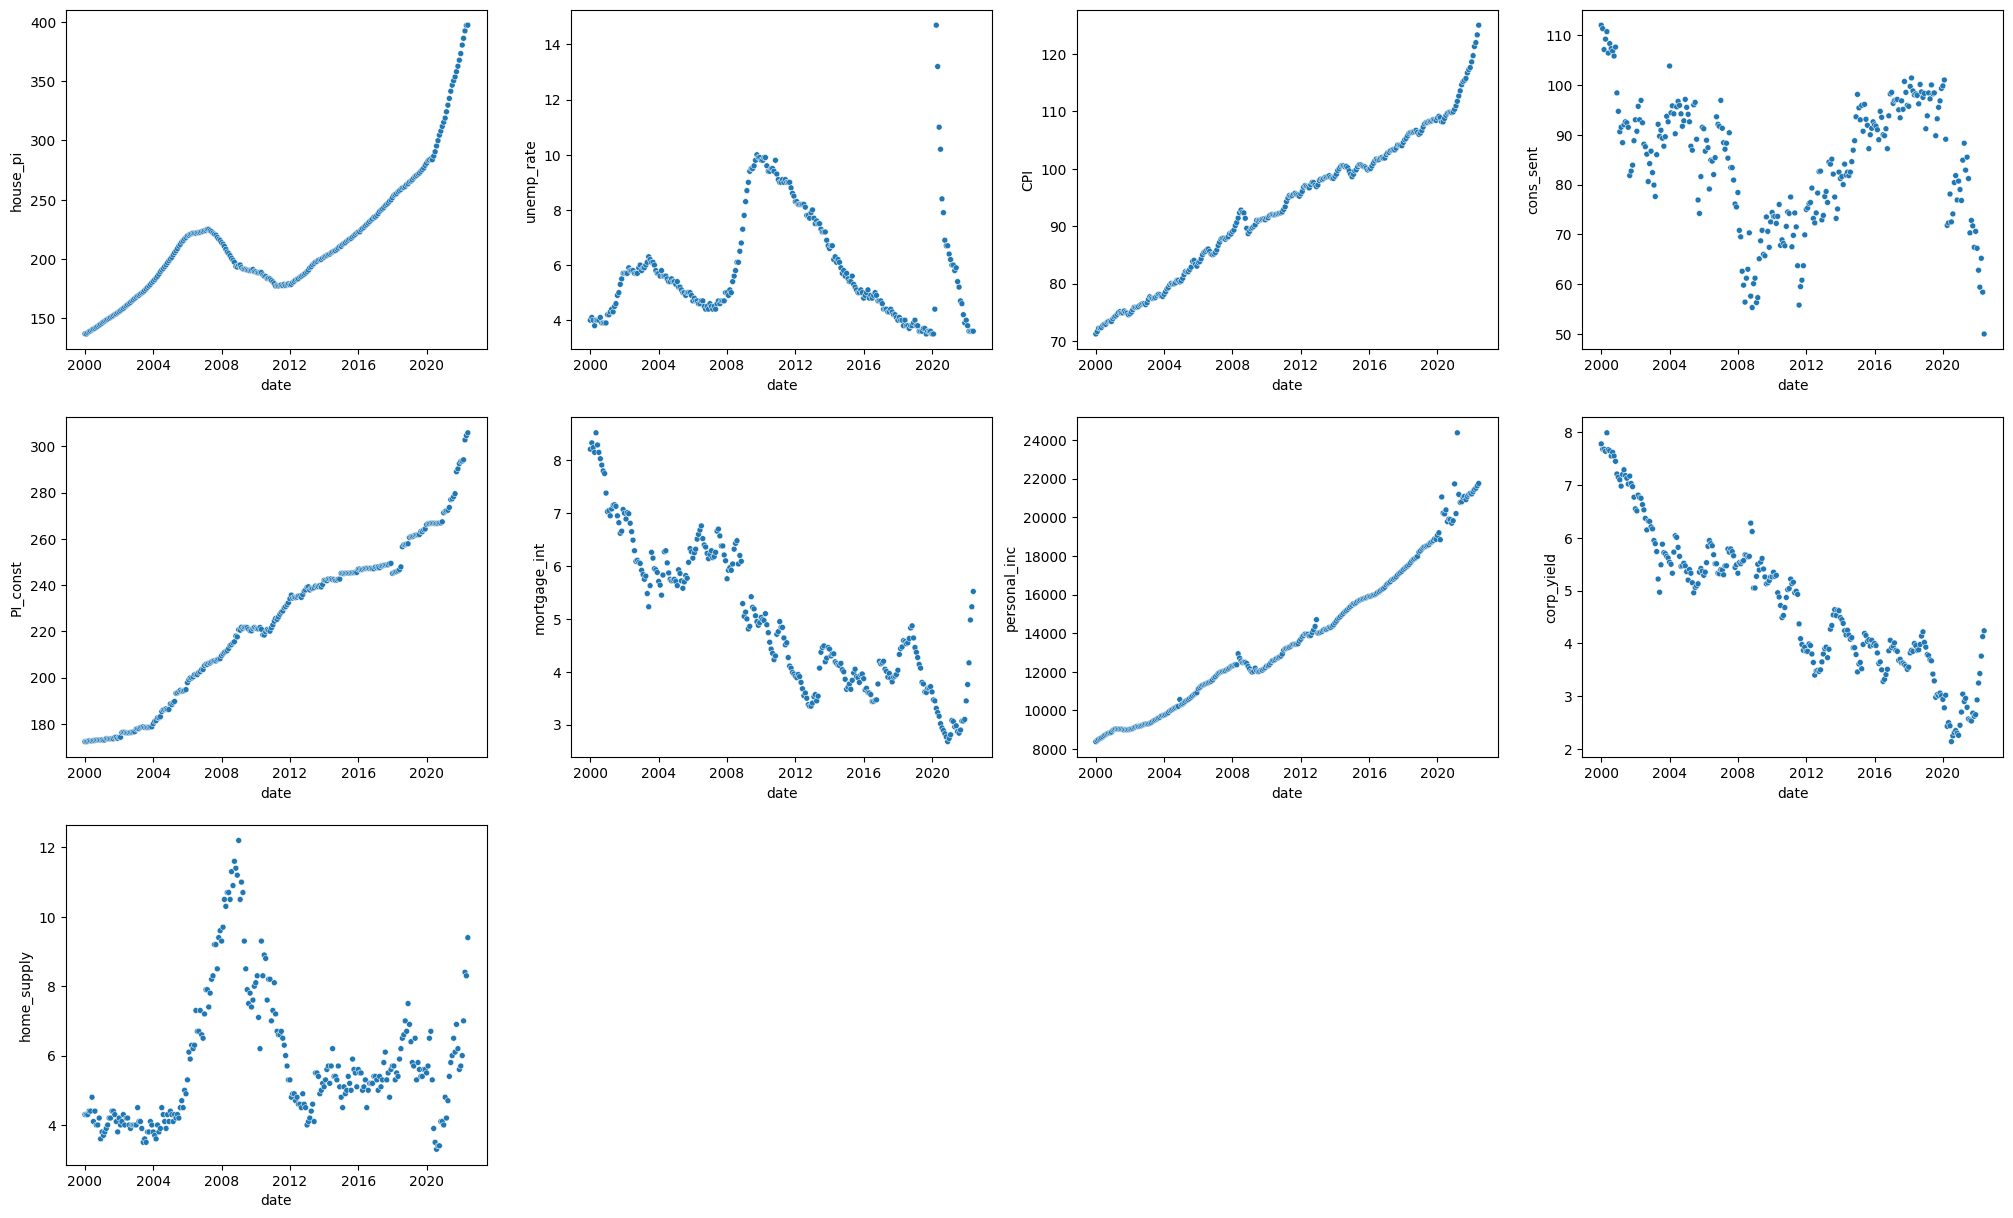

In [83]:
# plot how each variable evolves over time
cols = data.columns[1:,] # don't plot date against itself
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = data['date'], y = i, size = 5, legend = False)
    k += 1

Interpretation:
- 'house_pi' has a clearly upwards-sloping trend with a serious uptick in the years leading up to the year 2007/08. This is not surprising as we know today that in the build-up of the subprime crisis real estate prices skyrocketed before the housing price bubble burst. After a short period of price corrections up until ca. the year 2012, the prices have again risen and still are.
- 'unemp_rate' has seen upticks after every major crisis - dotcom bubble in the early 21st century, the financial crisis starting in 2008 and very recently the Corona pandemic.
- 'CPI' has steadily risen since the the beginning of the 21st century. Since and because of the corona pandemic and additionally fuelled by the on-going war in eastern Europe, we have seen major yoy increases in inflation. Central banks around the world have tried to get inflation under control by increasing interest rates which has not shown much effect up to the end of our sample time.
- 'cons_sent' paints a somewhat cyclical picture, marked by the recessions caused by the big crises in the 21st century thus far, as mentioned above.
- 'PI_const' looks, unsurprisingly, very similar to the broader 'CSI'. As such, it is also in line with our expectations.
- Up until ca. 2020, 'mortagage_int' exhibits a clear downwards-sloping trend sparked yet again by the recent crises. Since 2020, however, we observe a turnaround which is in close connection to the effort of central banks (especially the FED) to curb inflation.
- 'personal_inc' has experienced a steady upwards-sloping trend since the start date of our data set which obviously follows from the increase in inflation over the past centuries. Note, however, that naturally due to the nature of salary negotiations, the line is much smoother compared to the one of 'CPI'.
- 'corp_yield' has a very similar evolution over time as 'mortgage_int' which is not particularly surprising since for both, the prime rate has a very big impact.
- Lastly, the 'home_supply' has a slight upwards-sloping trend with a huge upwards move shortly before the subprime crisis. Notice, that while 'house_pi' started increasing rapidly after its low point, 'home_supply' had more of a slow trod before its volatilty started increasing from the year 2020 onwards.

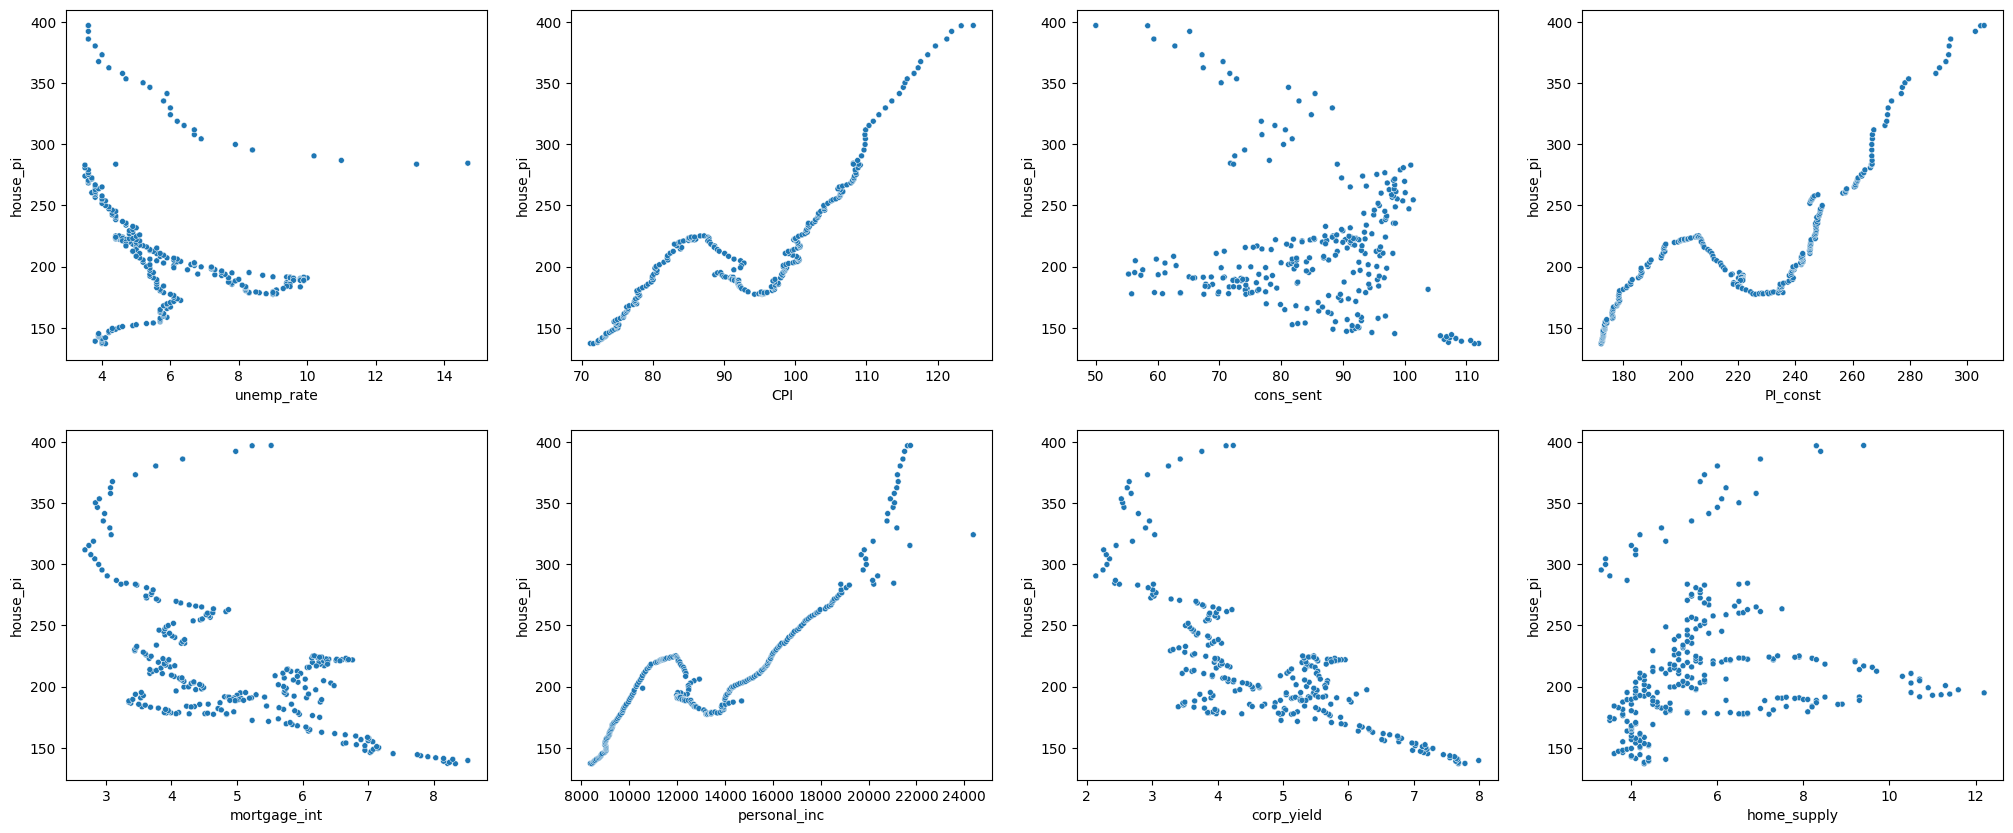

In [84]:
# plot all variables against the housing price index
cols = data.columns[2:,] # don't plot housing index against itself + see above for plot against time
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.scatterplot(data = data, x = i, y = data['house_pi'], size = 5, legend = False)
    k += 1

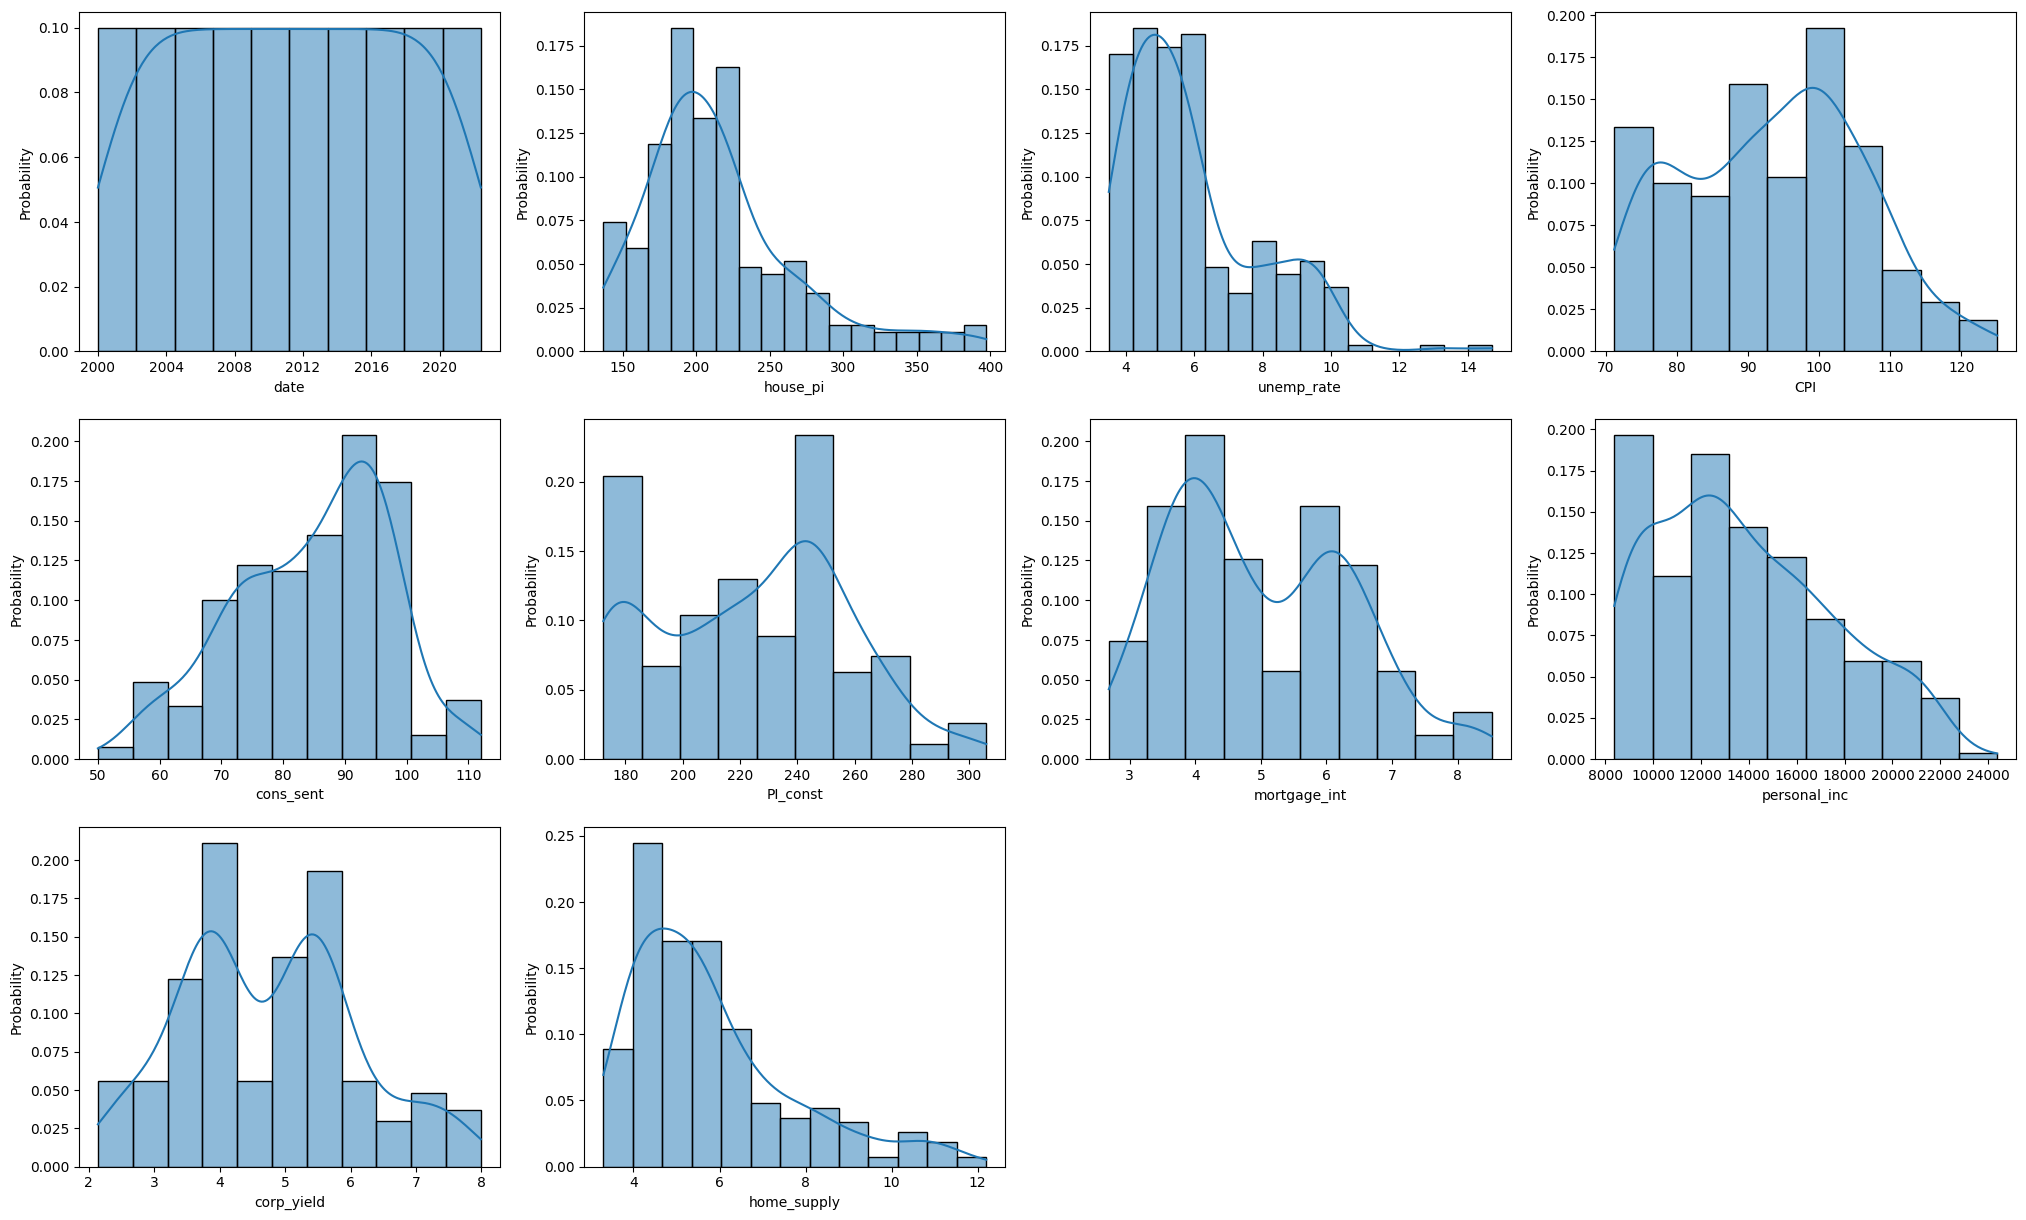

In [103]:
# distribution of the variables
cols = data.columns
n_rows = math.ceil(len(cols) / 4)
figsize_height = n_rows * 5
k = 1
plt.figure(figsize = (25, figsize_height))
for i in cols:
    plt.subplot(n_rows, 4, k)
    sns.histplot(data = data[i], stat = 'probability', kde = True)
    k += 1

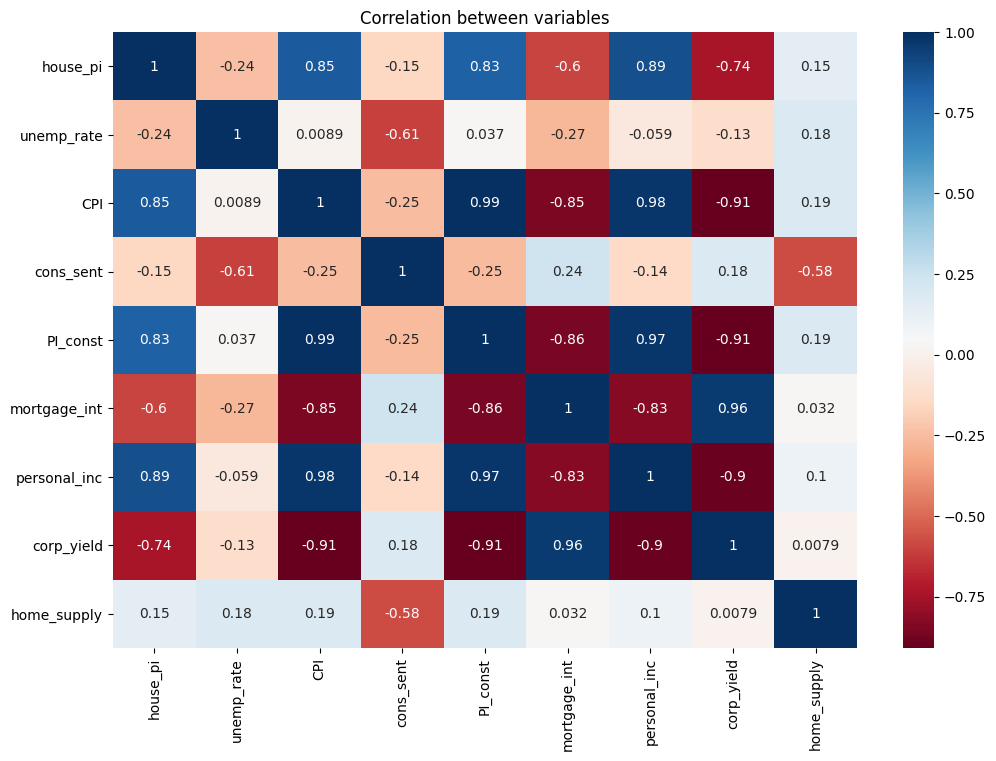

In [104]:
# correlation between the variables
plt.figure(figsize = (12, 8))
sns.heatmap(data.corr(), cmap = 'RdBu', annot = True)
plt.title('Correlation between variables')
plt.show()

## Modelling

### Cross-validation